# Bankruptcy Prediction: Metric Selection & Pattern Analysis

## Background
**Data:** US Company Bankruptcy Prediction Dataset (Kaggle) — NYSE/NASDAQ, 1999–2018  
Source: https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset

This project analyzes American public companies that ultimately filed for bankruptcy and compares them with firms that remained listed (“alive”) over the same period.

## Objective
Identify **5–10 financial metrics** that show **consistent, interpretable patterns** distinguishing failed from alive firms, suitable for early warning and prediction. Metrics will span **4 pillars**:  
1) **Financial Position**  
2) **Liquidity**  
3) **Profitability**  
4) **Capital Retention**

## Data Source
The dataset includes accounting data for NYSE/NASDAQ companies (1999–2018) with 18 fields:  
**Current Assets, Cost of Goods Sold, Depreciation & Amortization, EBITDA, Inventory, Net Income, Total Receivables, Market Value, Net Sales, Total Assets, Total Long-term Debt, EBIT, Gross Profit, Total Current Liabilities, Retained Earnings, Total Revenue, Total Liabilities, Total Operating Expenses.**

## Analysis Approach (OSE)

**Scope note.** This notebook focuses on O–S–E. Predictive modeling and interpreation are intentionally deferred; thresholds below are meant for descriptive early-warning monitoring.

### Environment Set-Up and Loading Dependencies
- Import necessary packages.
  
### Obtain the Data
- Load the Kaggle NYSE/NASDAQ (1999–2018) cvs file.

### Scrub the Data
- Drop economically implausible negatives (e.g., Current Assets, Total Revenue).
- Engineer **Current Ratio** (CA/CL), **Working Capital** (CA−CL), **Net Assets** (TA−TL).

### Explore & Visualize 
- Build *alive* vs *failed* cohorts.
- Align timelines so **t = 0** = bankruptcy (failed) or last observed year (alive).
- Visualization 1: Boxplot of Accounting Metrics
- Visualization 2: Alive Companies vs Failed Companies Leading Up to Bankruptcy
- Visualization 3: Failed Firms Correlation Heatmap
- Visualization 4: Failed vs Alive Volatility 
- Visualization 5: Failed vs Alive Fundamentals
- Visualization 6: Failed Firms 2-Year Warning Windows
- Visualization 7: Failed Firms 4-Year Warning Windows

## Executive Summary

Aligned to **t = 0 (bankruptcy)**, failed firms show **125% higher volatility** and **28% weaker fundamentals** than alive peers. Beginning **2–4 years** pre-bankruptcy, year-over-year fundamentals decline **~9× faster**, defining a practical early-warning window.

## Recommendations (Operational Thresholds)

1) Persistent volatility uplift — *Liquidity/retention volatility signal*  
2) Widening fundamentals gap — *Level deterioration signal*  
3) Early warning (broad revenue/earnings pressure)  
4) Late warning (balance-sheet stress) 

## Environment Set-Up and Loading Dependencies

In [50]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20,5)
pd.set_option('display.max_columns', None)
df = pd.read_csv("american_bankruptcy.csv")

## Obtain the Data

In [107]:
df.head()

,company_name,status_label,year,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market Value,Net Sales,Total Assets,Total Long-term Debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [109]:
df.tail()

,company_name,status_label,year,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market Value,Net Sales,Total Assets,Total Long-term Debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses
78677,C_8971,alive,2014,233.211,43.338,14.094,45.615,3.376,25.261,22.846,756.4827,104.223,1099.101,184.666,31.521,60.885,28.197,28.095,104.223,225.887,58.608
78678,C_8971,alive,2015,105.559,59.184,42.592,202.133,2.288,129.688,54.611,527.5750,291.153,1865.926,770.103,159.541,231.969,88.128,157.783,291.153,880.327,89.020
78679,C_8971,alive,2016,63.971,69.074,65.057,79.051,2.581,-1.442,42.467,578.8868,169.858,1746.235,683.985,13.994,100.784,85.765,156.341,169.858,770.233,90.807
78680,C_8971,alive,2017,135.207,66.527,65.330,69.171,2.013,-20.401,27.217,412.6241,161.884,1736.110,694.035,3.841,95.357,82.010,135.941,161.884,776.697,92.713
78681,C_8971,alive,2018,82.589,68.817,65.201,67.262,2.112,-50.946,45.839,354.1786,160.513,1625.370,632.122,2.061,91.696,79.365,84.995,160.513,712.687,93.251


In [111]:
print("Total number of companies =", df["company_name"].nunique())

Total number of companies = 8971


#####
*The columns and data look consistent at top and bottom of the dataset.  There appear to be 78,681 rows and 8,971 companies from 1999 to 2018.*
#####

## Scrub the Data

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_name                   78682 non-null  object 
 1   status_label                   78682 non-null  object 
 2   year                           78682 non-null  int64  
 3   Current assets                 78682 non-null  float64
 4   Cost of goods sold             78682 non-null  float64
 5   Depreciation and amortization  78682 non-null  float64
 6   EBITDA                         78682 non-null  float64
 7   Inventory                      78682 non-null  float64
 8   Net Income                     78682 non-null  float64
 9   Total Receivables              78682 non-null  float64
 10  Market Value                   78682 non-null  float64
 11  Net Sales                      78682 non-null  float64
 12  Total Assets                   78682 non-null 

#####
*The data appears to be fully clean with 78,682 line items for each column.  It does not require cleaning from data consistency perspective.  Next I will check whether the range of the data in each column makes sense.* 
#####

In [115]:
df.describe()

,year,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market Value,Net Sales,Total Assets,Total Long-term Debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses
count,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,7.868200e+04,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
mean,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,3.414355e+03,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,1.841410e+04,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,1.000000e-04,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,3.498000e+01,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,2.275118e+02,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,1.244890e+03,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250
max,2018.000000,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


#####
*Some of the minimums are negative for some of the columns when they shouldn't be based on how accounting data works.  This may be an error in the data. I am now going to check how many instances are negative and whether it makes sense to remove those companies.*
#####

In [117]:
# Step 1: Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Step 2: For each numeric column, create a mask of negative values
negatives = df[numeric_cols] < 0

# Step 3: Combine with status_label and groupby to count negatives per status
negative_counts_by_status = df.assign(**negatives).groupby("status_label")[numeric_cols].sum()

negative_counts_by_status

,year,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market Value,Net Sales,Total Assets,Total Long-term Debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses
status_label,,,,,,,,,,,,,,,,,,,
alive,0,6,4,0,21044,0,30828,1,0,13,0,1,25984,6014,0,36878,13,0,2
failed,0,0,2,0,1968,0,3173,0,0,0,0,0,2514,589,0,3399,0,0,1


#####
*Certain financial statement items—Current Assets, Cost of Goods Sold, Total Receivables, Net Sales, Total Long-term Debt, Total Revenue, and Total Operating Expenses—should not be negative under standard reporting conventions. To keep the analysis within plausible accounting ranges, I will exclude company observations where any of these fields are negative for any year. These cases occur in both the alive and failed cohorts and appear to be rare, so the exclusion should have minimal impact on results; I’ll also report the number of dropped rows by cohort as a sanity check.* 
#####

In [390]:
# Step 1: Define the columns to check
columns_to_check = [
    "Current assets",
    "Cost of goods sold",
    "Total Receivables",
    "Net Sales",
    "Total Long-term Debt",
    "Total Revenue",
    "Total Operating Expenses"
]

# Step 2: Find companies with any negative value in any of those columns
bad_companies = df[df[columns_to_check].lt(0).any(axis=1)]["company_name"].unique()

# Step 3: Remove all rows for those companies
df_cleaned = df[~df["company_name"].isin(bad_companies)].copy()

df_cleaned.describe()

,year,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market Value,Net Sales,Total Assets,Total Long-term Debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses
count,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,7.854100e+04,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000,78541.000000
mean,2007.504679,881.867963,1597.352420,121.444416,377.511128,201.965170,129.700166,287.341298,3.419797e+03,2368.273509,2872.021997,723.748356,256.066580,770.921195,611.127430,533.750426,2368.273509,1776.645219,1990.762406
std,5.743148,3931.925090,8938.247892,652.943041,2013.731057,1061.683875,1266.624831,1337.123250,1.843006e+04,11960.365646,12929.003586,3244.941056,1495.903832,3777.928345,2940.916678,6374.774476,11960.365646,8060.579282,10428.648824
min,1999.000000,0.001000,0.000000,0.000000,-21913.000000,0.000000,-98696.000000,0.000000,1.000000e-04,0.001000,0.001000,0.000000,-25913.000000,-21536.000000,0.001000,-102362.000000,0.001000,0.001000,0.000000
25%,2002.000000,19.010000,17.154000,1.200000,-0.793000,0.001000,-7.387000,3.306000,3.514190e+01,27.752000,37.573000,0.000000,-2.762000,8.609000,8.934000,-68.120000,27.752000,13.554000,33.072000
50%,2007.000000,100.913000,104.425000,7.982000,15.198000,7.091000,1.640000,22.969000,2.282844e+02,187.868000,214.030000,7.667000,6.594000,64.016000,43.545000,-1.070000,187.868000,82.369000,170.097000
75%,2012.000000,432.576000,636.330000,48.139000,140.166000,75.000000,40.324000,132.042000,1.248576e+03,1049.632000,1174.300000,249.545000,87.899000,345.222000,223.323000,146.617000,1049.632000,632.394000,877.663000
max,2018.000000,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


#####
*After excluding economically implausible negatives, the dataset now aligns with standard accounting sign conventions. Next, I’ll quantify the impact of this filter by reporting how many rows and distinct companies remain in the cleaned sample.*
#####

In [121]:
print("Total number of cleaned companies =", df_cleaned["company_name"].nunique())

Total number of cleaned companies = 8953


In [123]:
bankrupt_status = df_cleaned.groupby("company_name")["status_label"].max()
count_bankrupt = (bankrupt_status == "failed").sum()
print("Total number of cleaned failed companies =", count_bankrupt)

Total number of cleaned failed companies = 607


In [125]:
count_alive = (bankrupt_status != "failed").sum()
print("Total number of cleaned alive companies =", count_alive)

Total number of cleaned alive companies = 8346


#####
*After cleaning, the sample contains 607 firms that filed for bankruptcy and 8,346 that remained alive.*

*To enrich the feature set, I’ll engineer three fundamentals that aren’t currently standalone fields — Net Assets (Total Assets − Total Liabilities), Current Ratio (Current Assets ÷ Total Current Liabilities), and Working Capital (Current Assets − Total Current Liabilities). These measures capture liquidity and balance-sheet strength and are often cited as early signals of distress. Adding them will let me test their incremental value alongside the existing metrics.*
#####

In [141]:
df_calcs = df_cleaned.copy(deep=True)

df_calcs["Net Assets"] = df_calcs["Total Assets"] - df_calcs["Total Liabilities"]

In [143]:
# Liquidity Ratios
df_calcs["Current Ratio"] = df_calcs["Current assets"] / df_calcs["Total Current Liabilities"]
df_calcs["Working Capital"] = df_calcs["Current assets"] - df_calcs["Total Current Liabilities"]

In [145]:
df_calcs.head()

,company_name,status_label,year,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market Value,Net Sales,Total Assets,Total Long-term Debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses,Net Assets,Current Ratio,Working Capital
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302,339.515,3.120983,347.451
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888,340.212,3.874697,360.464
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514,310.235,2.902063,286.192
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592,294.988,1.947253,192.837
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467,301.684,3.292707,300.943


#####
*These three columns have been added successfully.  There are now 21 metrics in the dataset to explore.*
#####

## Explore & Visualize the Data

### Visualization 1: Boxplot of Accounting Metrics

*How do failed companies differ from alive companies across the 21 metrics over all years?*

*To answer this, I will split the dataset into two subsets—failed and alive—and compare the distributions between the two groups.*

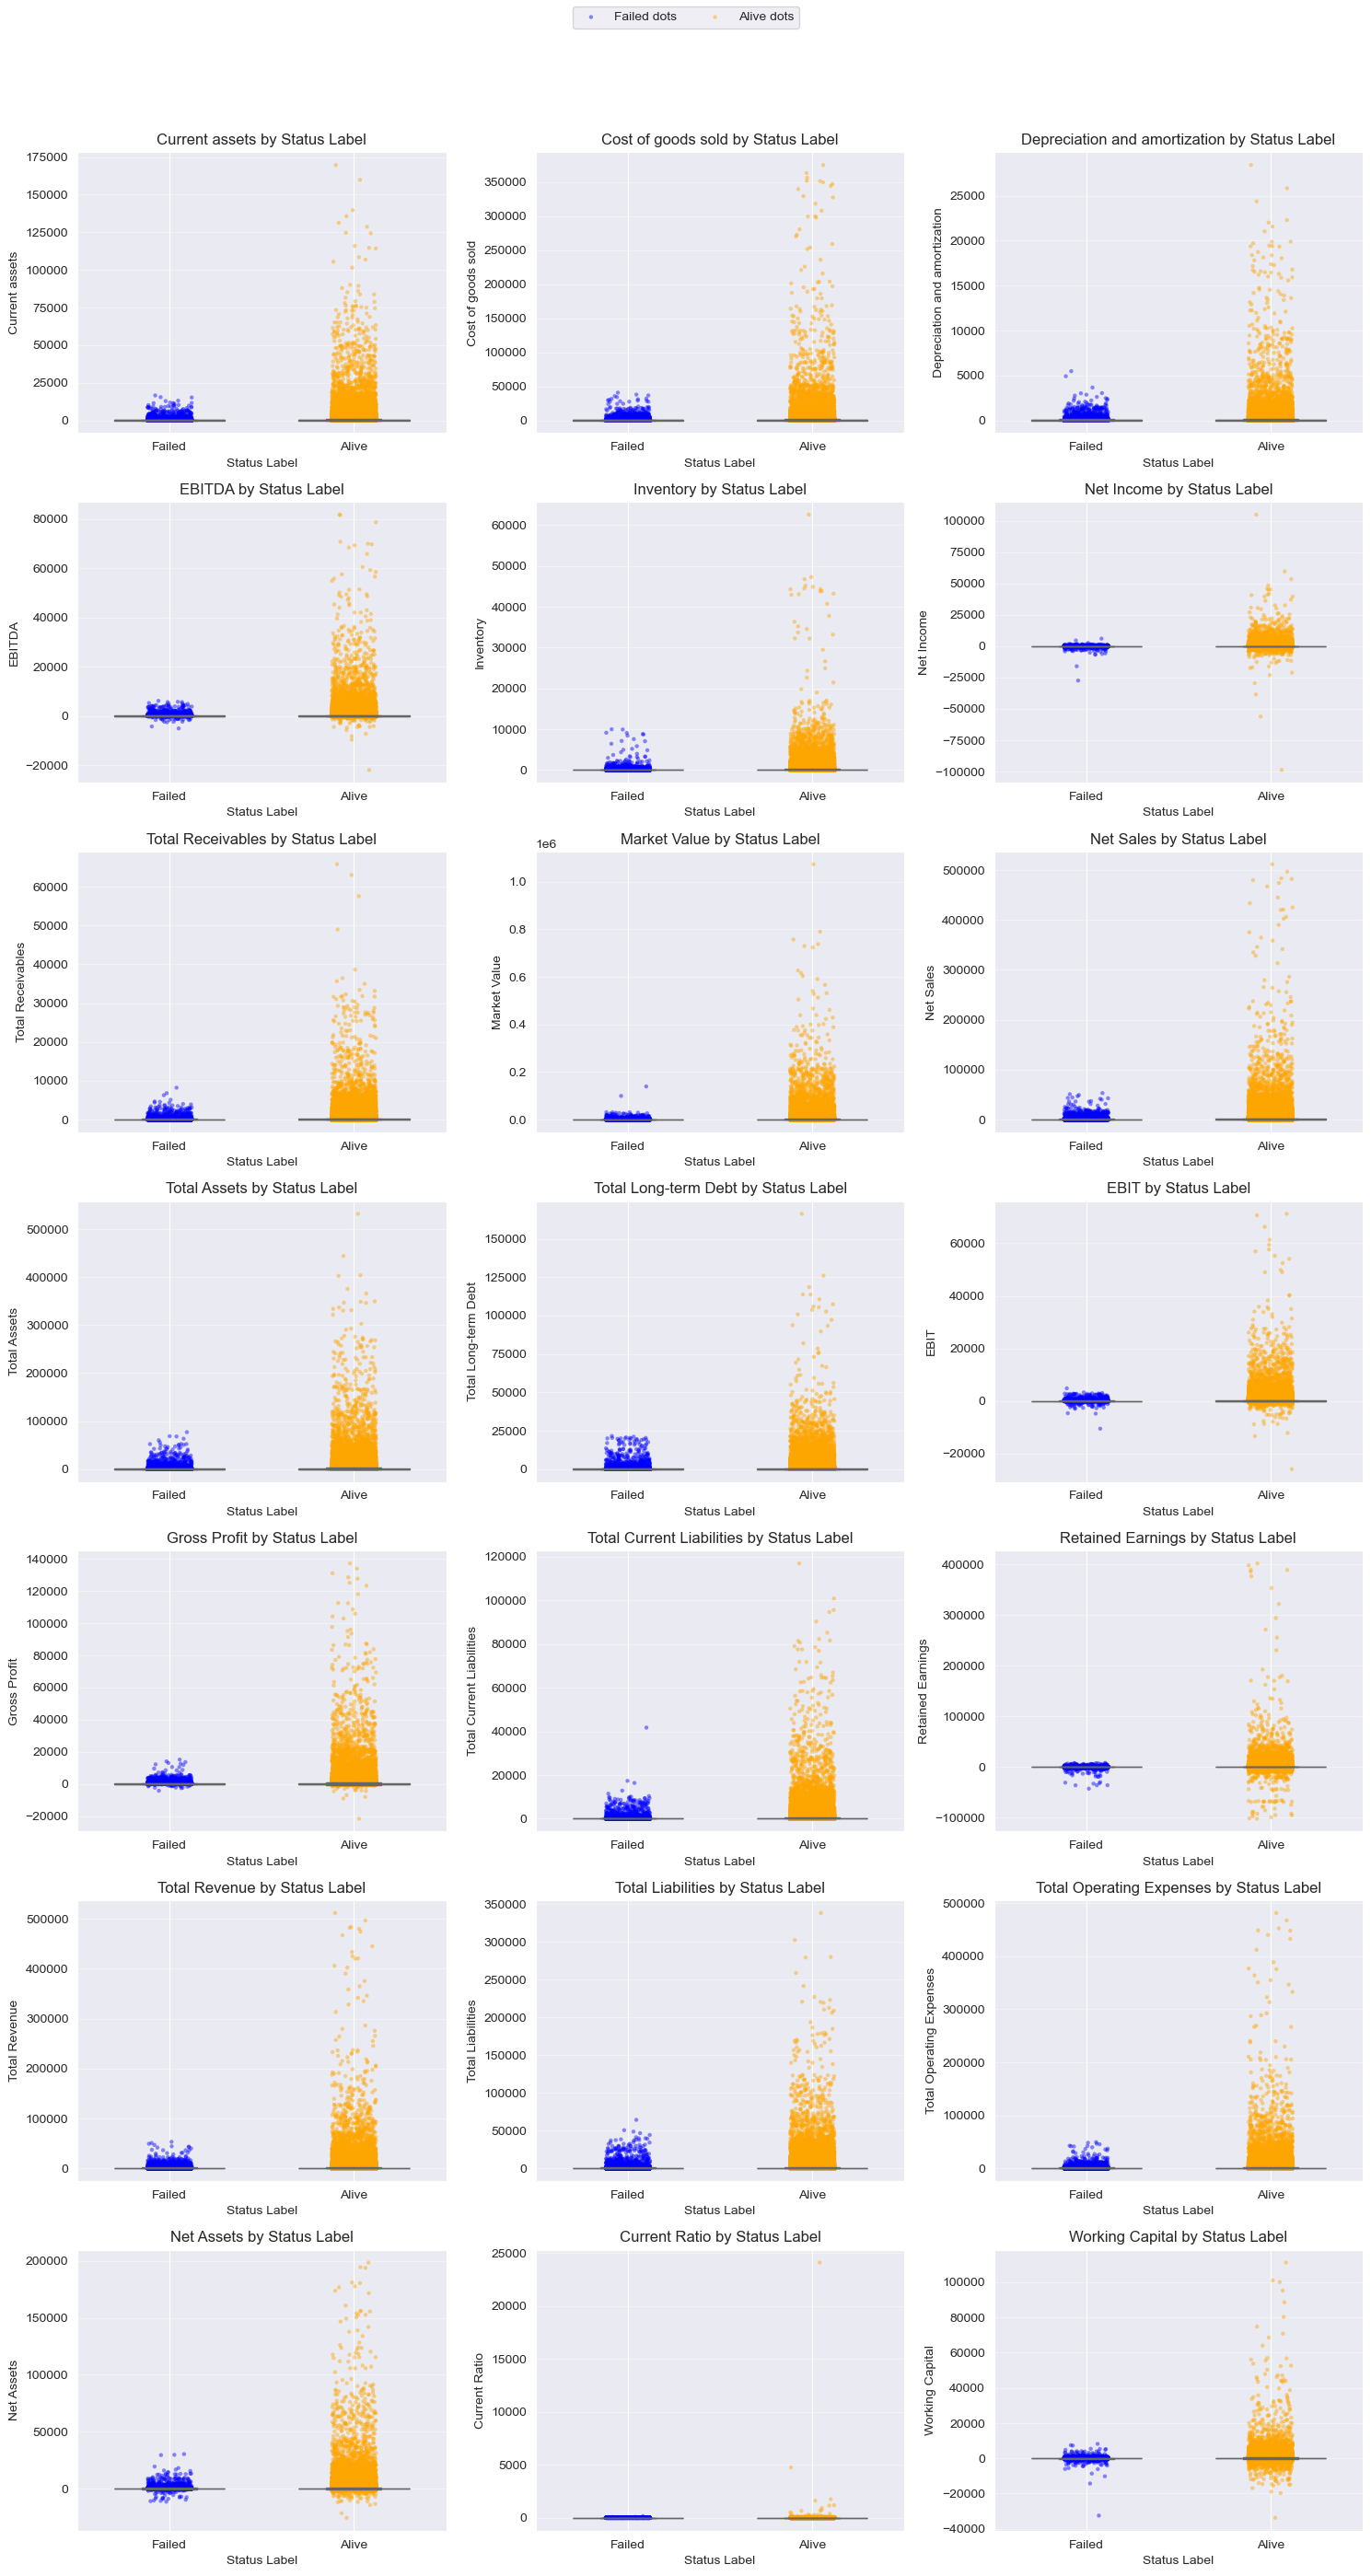

In [394]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Select numeric columns to plot (skip ID/timestamp-like cols)
numeric_cols = df_calcs.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in ["year"]]

# Step 2: Setup subplot grid
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Group masks
status = df_calcs["status_label"].astype(str).str.lower()
alive_mask  = status.eq("alive")
failed_mask = status.eq("failed")

rng = np.random.default_rng(42)  # reproducible jitter

for i, col in enumerate(numeric_cols):
    ax = axes[i]

    y_failed = df_calcs.loc[failed_mask, col].dropna().values
    y_alive  = df_calcs.loc[alive_mask,  col].dropna().values

    # Boxplots WITHOUT labels arg (avoid deprecation), then set ticks below
    bp = ax.boxplot(
        [y_failed, y_alive],
        positions=[0, 1],
        widths=0.6,
        patch_artist=True,
        showfliers=False
    )

    # Neutral box styling so dots stand out
    for box in bp["boxes"]:
        box.set(facecolor="#eeeeee", edgecolor="#666666")
    for element in ["whiskers", "caps", "medians"]:
        for line in bp[element]:
            line.set(color="#666666")

    # Jittered dots: Failed=blue, Alive=orange
    ax.scatter(0 + rng.uniform(-0.12, 0.12, size=len(y_failed)), y_failed,
               s=10, alpha=0.45, color="blue",   edgecolors="none",
               label="Failed dots" if i == 0 else None)
    ax.scatter(1 + rng.uniform(-0.12, 0.12, size=len(y_alive)),  y_alive,
               s=10, alpha=0.45, color="orange", edgecolors="none",
               label="Alive dots"  if i == 0 else None)

    # Set tick labels here (works on all Matplotlib versions)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Failed", "Alive"])

    ax.set_title(f"{col} by Status Label")
    ax.set_xlabel("Status Label")
    ax.set_ylabel(col)
    ax.grid(True, axis="y", alpha=0.35)

# Drop any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# One legend for dots
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=True)

plt.suptitle("")
plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

#####
*The accounting metrics for failed companies tend to cluster much closer to 0 compared with those of alive companies. Their ranges are also narrower, and bankrupt firms show relatively few outliers.*  

*Since the major accounting indicators move in similar ways, the following metrics stand out as particularly worth exploring further:*  

- Total Assets  
- Net Assets  
- Total Liabilities 
- EBIT
- EBITDA  
- Gross Profit  
- Net Income  
- Market Value  
- Retained Earnings  
- Total Revenue  
- Current Ratio  
- Working Capital  

*The other measures—including Current Assets, Cost of Goods Sold, Depreciation and Amortization, Inventory, Total Receivables, Net Sales, Long-term Debt, Current Liabilities, and Operating Expenses—remain relevant, but largely feed into or are components of the primary metrics above, and are therefore captured indirectly in the analysis.*  

### Visualization 2: Alive Companies vs Failed Companies Leading Up to Bankruptcy

*How do these metrics relate to bankruptcy over time?*

*To evaluate this, I will normalize the timelines for both groups. For alive companies, year 0 will represent 2018 or the point at which they are delisted from the exchange for reasons other than bankruptcy, with prior years labeled as -1, -2, etc. For Failed companies, year 0 will represent the year of bankruptcy, with earlier years labeled in the same way. This alignment allows for comparing patterns in the years leading up to bankruptcy.*

In [189]:
#Noramlization of Alive Companies

# Step 1: Identify the last year for each company
last_year_a_idx = df_calcs.groupby("company_name")["year"].idxmax()
last_year_a_rows = df_calcs.loc[last_year_a_idx]

# Step 2: Filter companies that are "active"
alive_companies = last_year_a_rows[last_year_a_rows["status_label"] == "alive"]["company_name"]

# Step 3: Create a copy of df_calcs with only active companies
df_alive = df_calcs[df_calcs["company_name"].isin(alive_companies)].copy()

# Step 4: Map each active company's last year as their reference "exit year"
exit_year_map = df_alive.groupby("company_name")["year"].max()
df_alive["exit_year"] = df_alive["company_name"].map(exit_year_map)

# Step 5: Compute relative year (year 0 = last year in data)
df_alive["years_before_exit"] = df_alive["year"] - df_alive["exit_year"]

In [187]:
#Normalization of Failed Companies

last_year_idx = df_calcs.groupby("company_name")["year"].idxmax()
last_year_rows = df_calcs.loc[last_year_idx]
failed_companies = last_year_rows[last_year_rows["status_label"] == "failed"]["company_name"]
df_failed = df_calcs[df_calcs["company_name"].isin(failed_companies)].copy()
failure_year_map = df_failed.groupby("company_name")["year"].max()
df_failed["failure_year"] = df_failed["company_name"].map(failure_year_map)
df_failed["years_before_failure"] = df_failed["year"] - df_failed["failure_year"]

*Now I will look at each of these metrics comparing the failed firms to the alive companies over time.* 

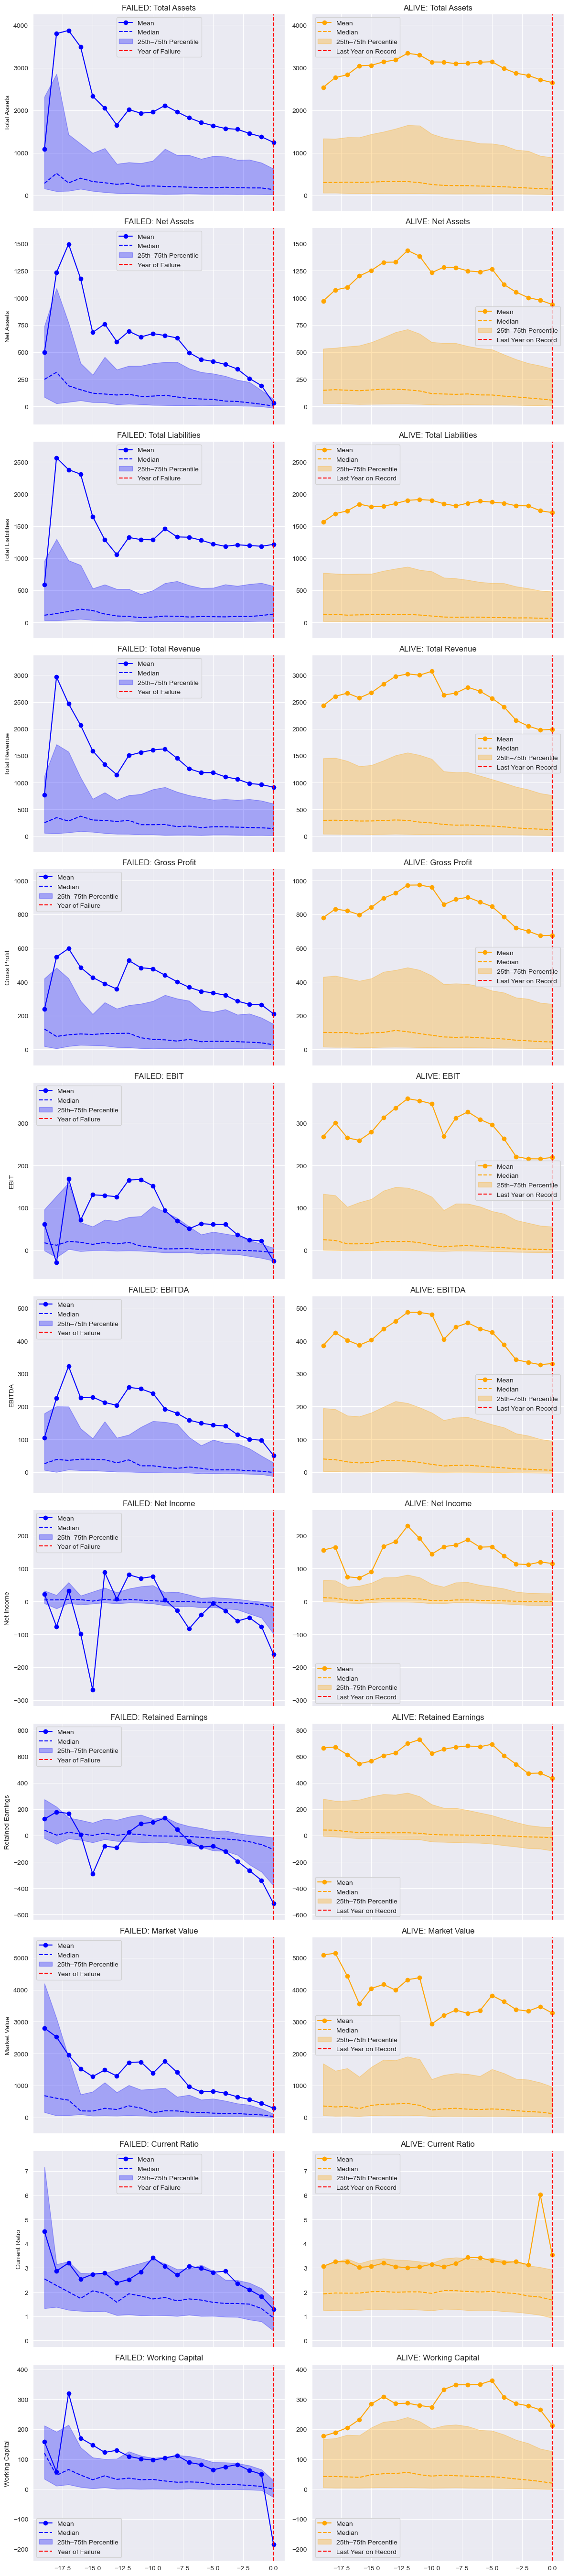

In [230]:
#Failed vs Alive Companies (mean, median, 25th percentile, 75th percentile)

# List of financial metrics to plot
metrics = [
    "Total Assets", "Net Assets", "Total Liabilities", "Total Revenue",
    "Gross Profit", "EBIT", "EBITDA", "Net Income", "Retained Earnings", "Market Value", "Current Ratio", "Working Capital"]

# Grid setup: rows = number of metrics, 2 columns (failed vs alive)
n_metrics = len(metrics)
fig, axes = plt.subplots(n_metrics, 2, figsize=(12, 4.5 * n_metrics), sharex=True)
axes = np.atleast_2d(axes)  # Ensure 2D shape even if n_metrics == 1

for i, metric in enumerate(metrics):
    # Grouped data
    grouped_failed = df_failed.groupby("years_before_failure")[metric]
    grouped_alive = df_alive.groupby("years_before_exit")[metric]

    mean_failed = grouped_failed.mean()
    median_failed = grouped_failed.median()
    q25_failed = grouped_failed.quantile(0.25)
    q75_failed = grouped_failed.quantile(0.75)

    mean_alive = grouped_alive.mean()
    median_alive = grouped_alive.median()
    q25_alive = grouped_alive.quantile(0.25)
    q75_alive = grouped_alive.quantile(0.75)

    # Compute shared y-axis limits
    y_min = min(mean_failed.min(), q25_failed.min(), mean_alive.min(), q25_alive.min())
    y_max = max(mean_failed.max(), q75_failed.max(), mean_alive.max(), q75_alive.max())
    y_padding = (y_max - y_min) * 0.1
    y_limits = (y_min - y_padding, y_max + y_padding)

    # ---- FAILED PLOT ----
    ax_f = axes[i, 0]
    ax_f.plot(mean_failed.index, mean_failed.values, label='Mean', marker='o', color='blue')
    ax_f.plot(median_failed.index, median_failed.values, label='Median', linestyle='--', color='blue')
    ax_f.fill_between(mean_failed.index, q25_failed.values, q75_failed.values, alpha=0.3, color='blue', label='25th–75th Percentile')
    ax_f.axvline(0, color='red', linestyle='--', label='Year of Failure')
    ax_f.set_title(f"FAILED: {metric}")
    ax_f.set_ylabel(metric)
    ax_f.set_ylim(y_limits)
    ax_f.grid(True)
    ax_f.legend()

    # ---- ALIVE PLOT ----
    ax_a = axes[i, 1]
    ax_a.plot(mean_alive.index, mean_alive.values, label='Mean', marker='o', color='orange')
    ax_a.plot(median_alive.index, median_alive.values, label='Median', linestyle='--', color='orange')
    ax_a.fill_between(median_alive.index, q25_alive.values, q75_alive.values, alpha=0.3, color='orange', label='25th–75th Percentile')
    ax_a.axvline(0, color='red', linestyle='--', label='Last Year on Record')
    ax_a.set_title(f"ALIVE: {metric}")
    ax_a.set_ylim(y_limits)
    ax_a.grid(True)
    ax_a.legend()

plt.tight_layout()
plt.show()

#####
*Across these metrics, the mean, median, and 75th percentile values appear to be higher for alive companies than for failed firms. Failed firms may also exhibit greater volatility, with metrics that seem to decline over time—potentially accelerating as bankruptcy approaches. In some cases, values even trend toward zero or negative territory. Taken together, these signals suggest meaningful differences between alive and failed companies across the metrics, though further analysis is needed to confirm the strength and significance of these patterns.*
#####

### Visualization 3: Failed Firms Correlation Heatmap

*Next, I will examine the correlations among these metrics for failed firms to determine whether the original list of 12 can be streamlined to around 8 without losing key information.*
#####

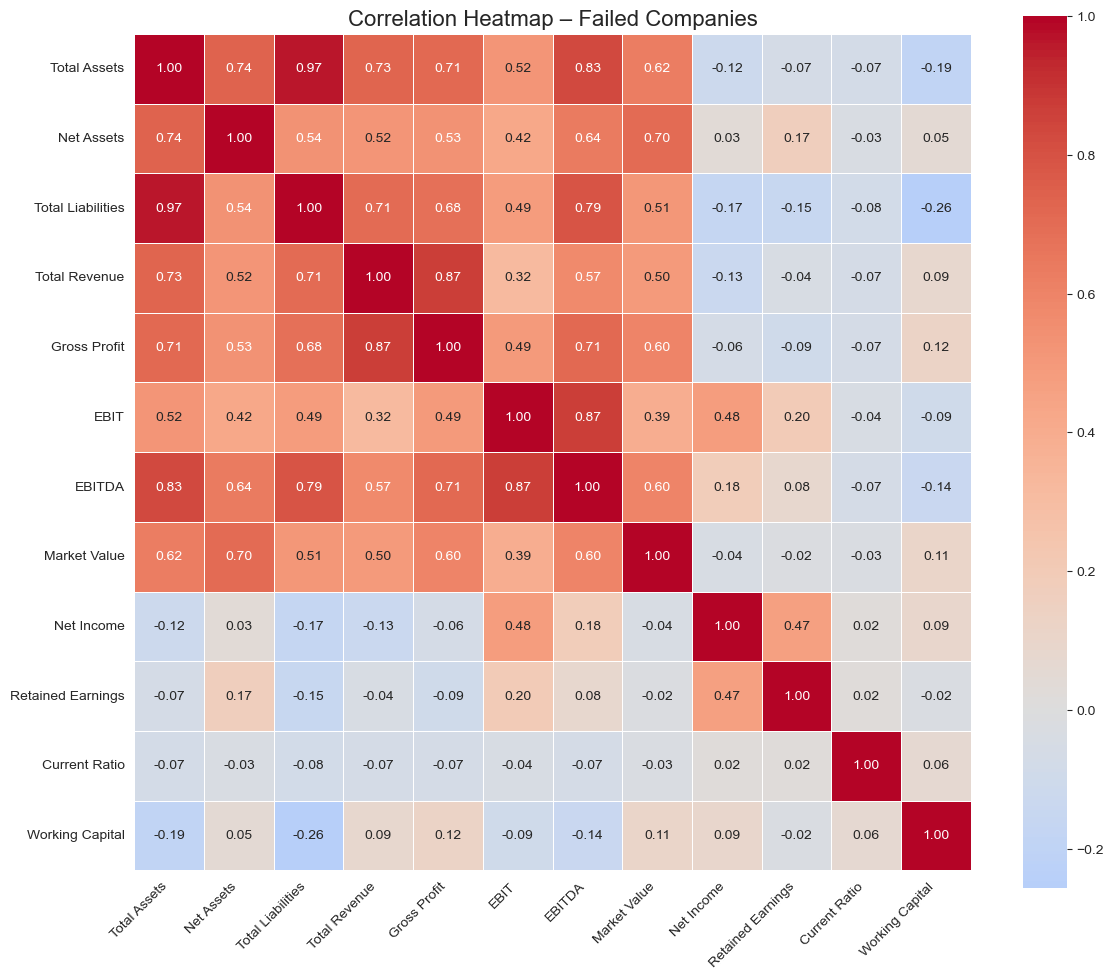

In [75]:
# Define column order
cols = [
    "Total Assets", "Net Assets", "Total Liabilities", "Total Revenue",
    "Gross Profit", "EBIT", "EBITDA", "Market Value", "Net Income", "Retained Earnings", "Current Ratio", "Working Capital"
]

# Drop rows with missing values
df_corr = df_failed[cols].dropna()

# Compute correlation matrix and reindex to match column order
corr_matrix = df_corr.corr().reindex(index=cols, columns=cols)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Correlation Heatmap – Failed Companies", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

*Because of the strong correlations among several measures—EBITDA and EBIT (0.87), Gross Profit and Total Revenue (0.87), and Total Assets and Total Liabilities (0.97), which together define Net Assets—the original 12 metrics can be streamlined down to 8 without losing explanatory power. These 8 metrics align well with the 4 categories of financial health defined in the objectives:*

1) Financial Position
  - **Net Assets**
  - **Market Value**
2) Liquidity
  - **Current Ratio**
  - **Working Capital**
3) Profitability
  - **Total Revenue**
  - **EBITDA**
  - **Net Income**
4) Capital Retention
  - **Retained Earnings**

### Visualization 4: Failed vs Alive Volatility

*Having narrowed the analysis to 8 key metrics that appear to differentiate failed firms from active companies, the next step is to examine whether the volatility of these metrics is in fact greater for failed firms than for alive firms over time.* 

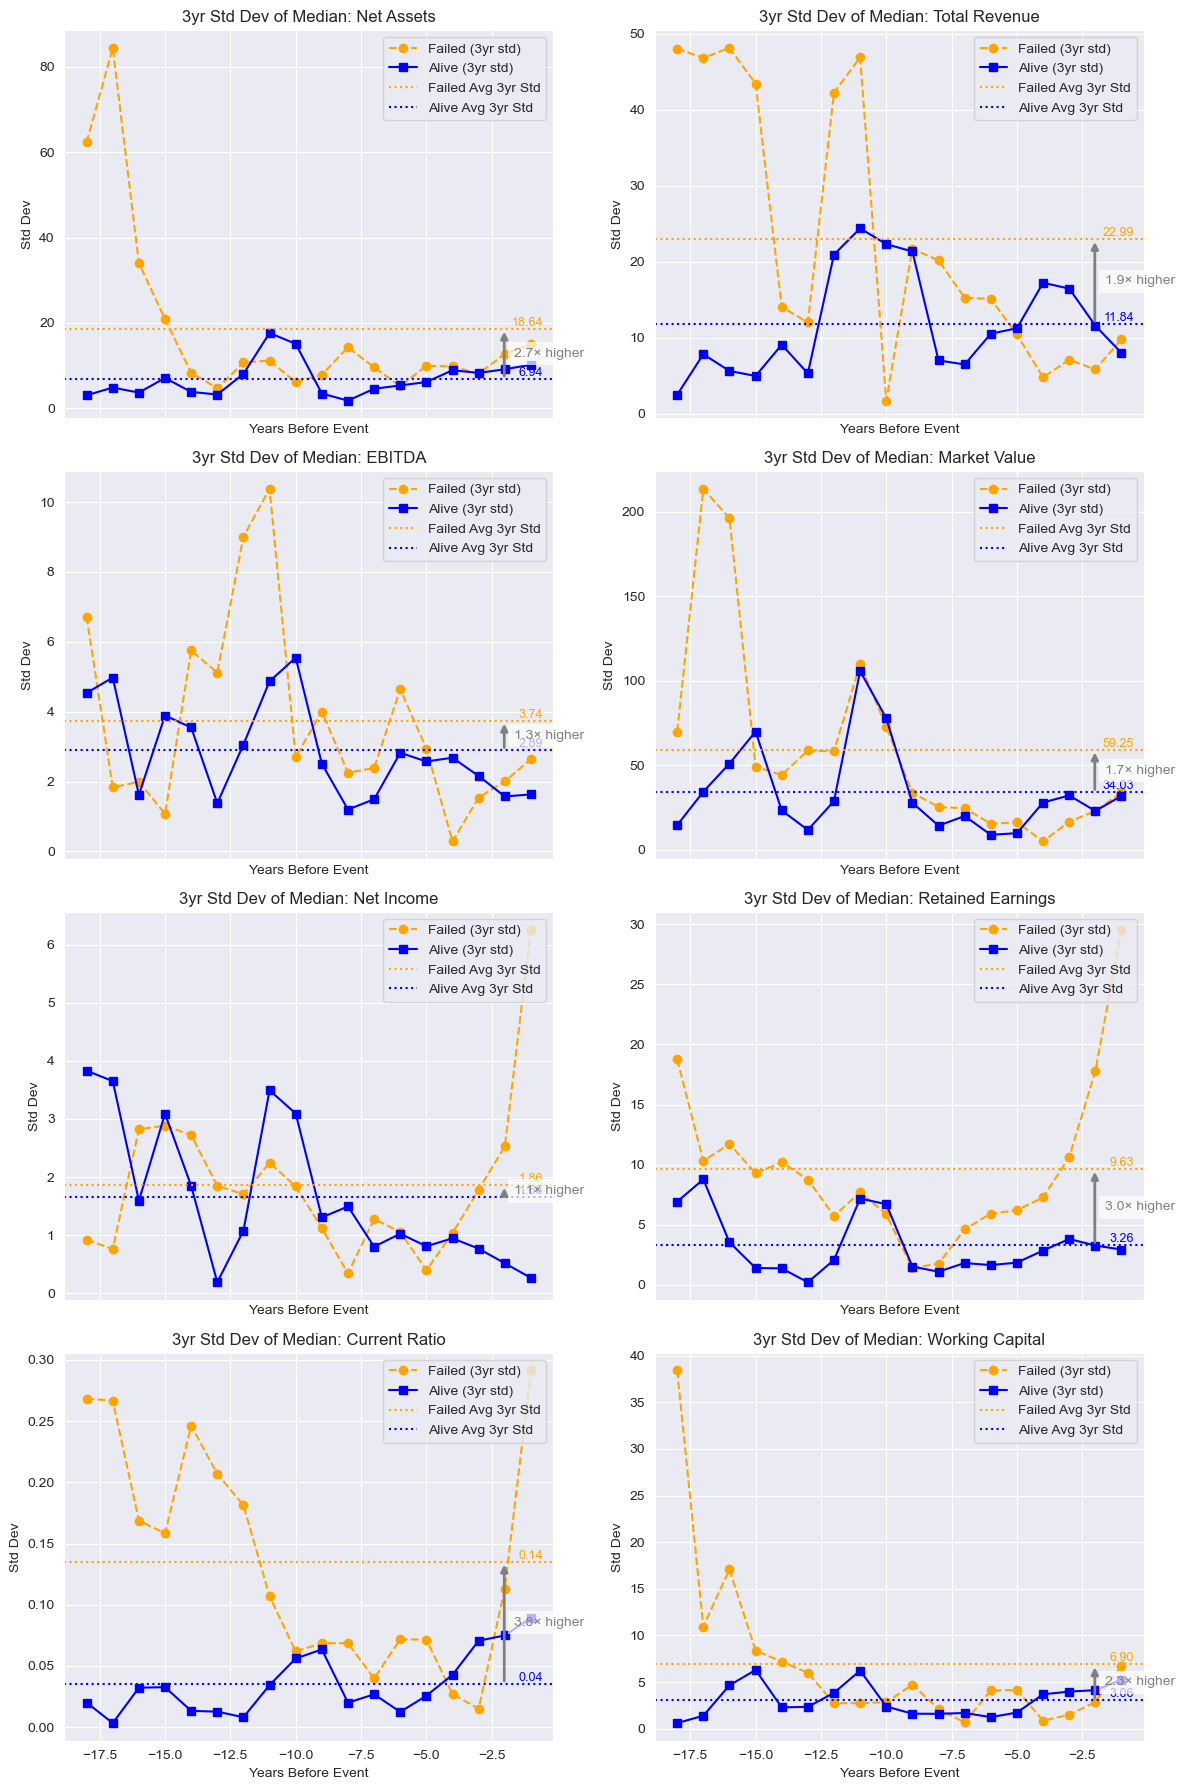

In [258]:
# Failed vs Alive 3 Year Rolling Standard Deviations

# Metrics to analyze
metrics = [
    "Net Assets", "Total Revenue",
    "EBITDA", "Market Value", "Net Income", "Retained Earnings",
    "Current Ratio", "Working Capital"
]

# Number of rows and columns for subplots
n_metrics = len(metrics)
n_cols = 2
n_rows = int(np.ceil(n_metrics / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows), sharex=True)
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Group by year and compute medians
    median_failed = df_failed.groupby("years_before_failure")[metric].median()
    median_alive = df_alive.groupby("years_before_exit")[metric].median()

    # 3-year rolling standard deviation of medians
    std_failed = median_failed.rolling(window=3, center=True).std()
    std_alive  = median_alive.rolling(window=3, center=True).std()

    # Plot the rolling std deviation curves
    ax.plot(std_failed.index, std_failed.values,
            label='Failed (3yr std)', color='orange', linestyle='--', marker='o')
    ax.plot(std_alive.index, std_alive.values,
            label='Alive (3yr std)', color='blue', linestyle='-',  marker='s')

    # --- Averages of 3-year rolling std ---
    avg_std_failed = std_failed.mean(skipna=True)
    avg_std_alive  = std_alive.mean(skipna=True)

    if not np.isnan(avg_std_failed):
        ax.axhline(y=avg_std_failed, color='orange', linestyle=':', label='Failed Avg 3yr Std')
        ax.annotate(f"{avg_std_failed:.2f}",
                    xy=(0.98, avg_std_failed),
                    xycoords=('axes fraction','data'),
                    ha='right', va='bottom',
                    fontsize=9, color='orange')

    if not np.isnan(avg_std_alive):
        ax.axhline(y=avg_std_alive, color='blue', linestyle=':', label='Alive Avg 3yr Std')
        ax.annotate(f"{avg_std_alive:.2f}",
                    xy=(0.98, avg_std_alive),
                    xycoords=('axes fraction','data'),
                    ha='right', va='bottom',
                    fontsize=9, color='blue')

    # --- Add arrow & ratio annotation (Alive → Failed, always pointing up) ---
    if np.isfinite(avg_std_alive) and np.isfinite(avg_std_failed) and avg_std_alive != 0:
        ratio = avg_std_failed / avg_std_alive
        label = f"{ratio:.1f}× higher"

        # Choose an x position near the right edge
        xmin, xmax = ax.get_xlim()
        x_span = xmax - xmin if xmax > xmin else 1.0
        x_annot = xmax - 0.1 * x_span

        # Always draw arrow up from Alive avg to Failed avg
        ax.annotate(
            '',
            xy=(x_annot, avg_std_failed),
            xytext=(x_annot, avg_std_alive),
            arrowprops=dict(arrowstyle='-|>', color='gray', lw=2),
            zorder=5
        )

        # Put label in the middle of the arrow
        y_mid = (avg_std_alive + avg_std_failed) / 2
        ax.text(
            x_annot + 0.02 * x_span, y_mid,
            label,
            va='center', ha='left', fontsize=10, color='gray',
            bbox=dict(fc='white', ec='none', alpha=0.7)
        )

    # Labels and titles
    ax.set_title(f"3yr Std Dev of Median: {metric}")
    ax.set_xlabel("Years Before Event")
    ax.set_ylabel("Std Dev")
    ax.grid(True)
    ax.legend(loc='upper right')

# Clean up extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

####
*Volatility is consistently higher among companies that eventually failed compared with those that remained alive across all 8 key metrics. Failed firms exhibit elevated variability in every case—with Current Ratio showing the largest gap (3.8× higher) and Net Income the smallest (1.1× higher) relative to alive companies. The fact that volatility is uniformly greater across all fundamentals strengthens the signal that instability is a distinguishing feature of failed firms, suggesting that heightened variability itself may be an important early indicator of financial distress.*
####

### Visualization 5: Failed vs Alive Fundamentals

*Next I will explore whether the means actually are different between failed firms and alive companies over time.*

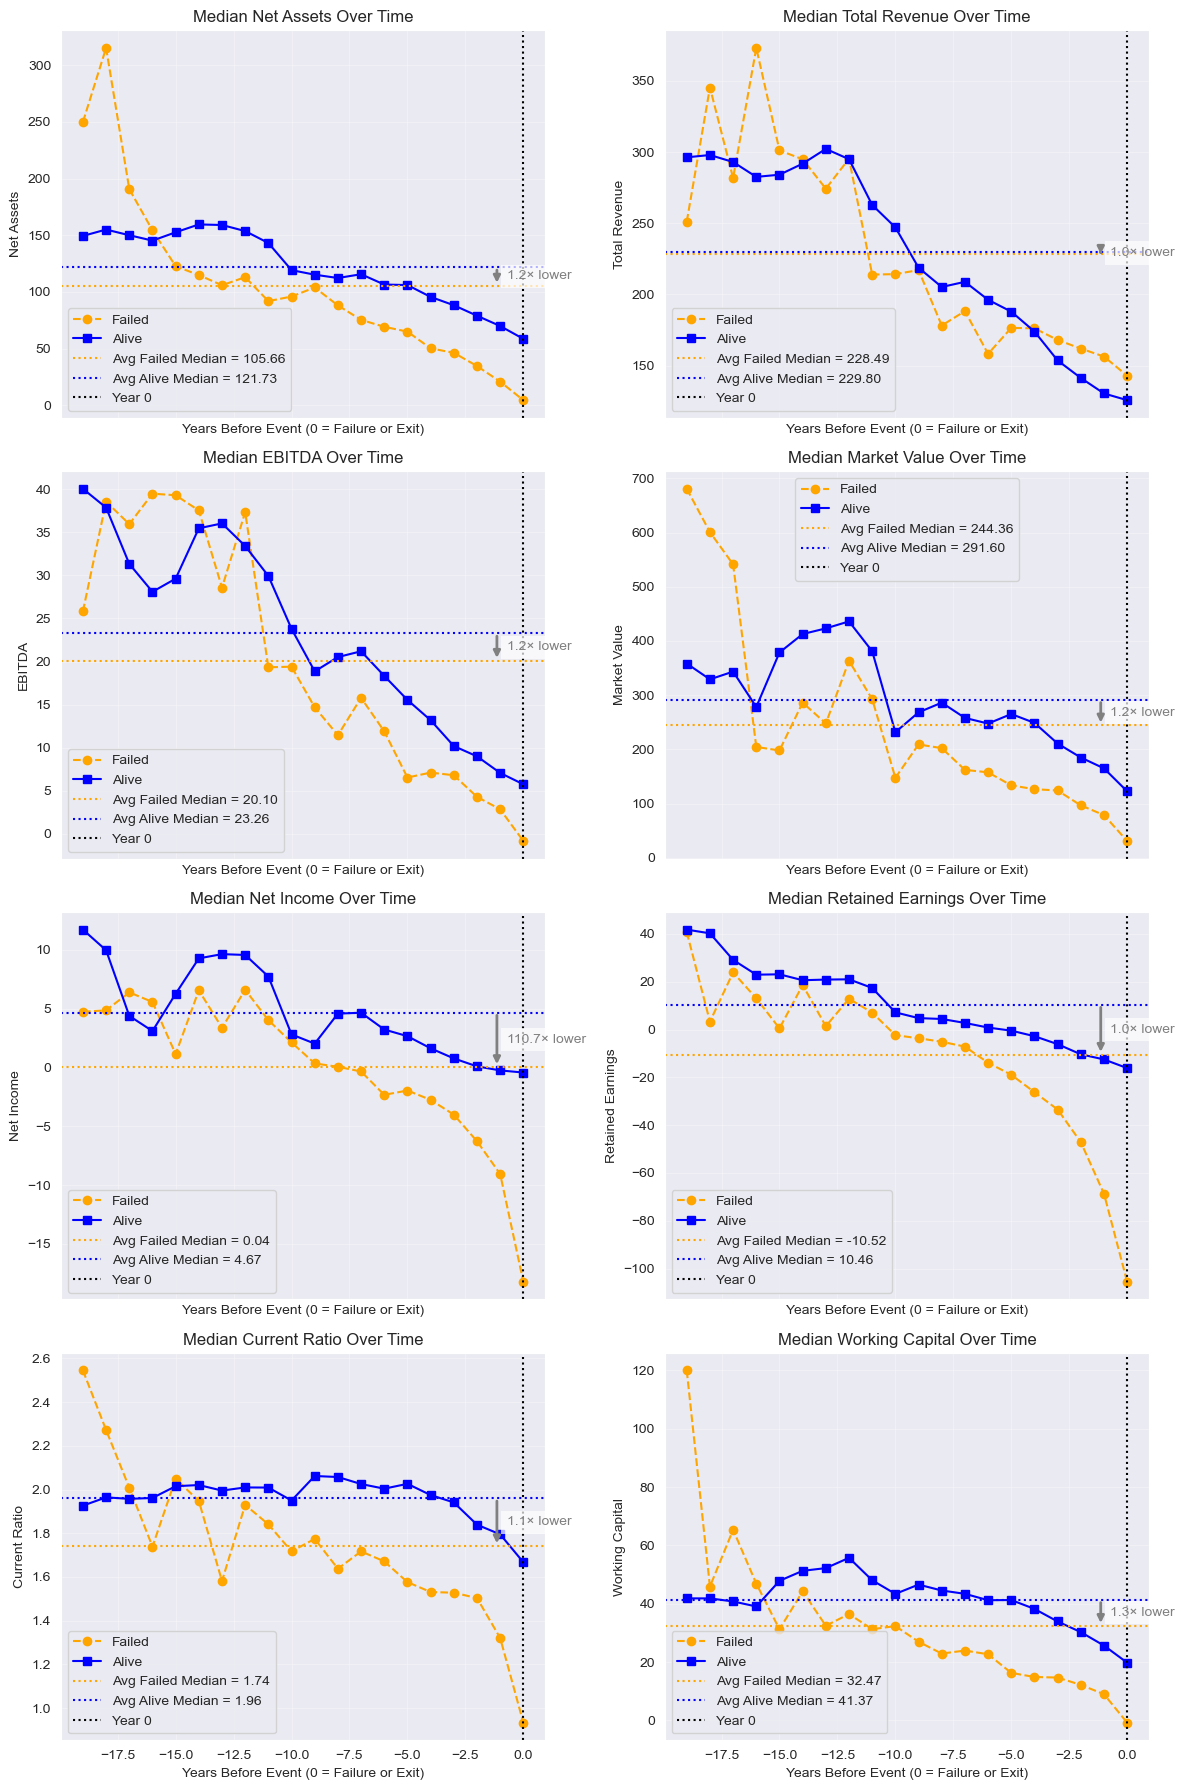

In [274]:
# Failed vs Alive Medians, Failed Values are "Low" as compared to Alive values?

# List of financial metrics to compare
metrics = [
    "Net Assets", "Total Revenue",
    "EBITDA", "Market Value", "Net Income", "Retained Earnings",
    "Current Ratio", "Working Capital"
]

# Number of rows and columns for subplots
n_metrics = len(metrics)
n_cols = 2
n_rows = int(np.ceil(n_metrics / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows), sharex=True)
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Group by relative year and calculate medians
    median_failed = df_failed.groupby("years_before_failure")[metric].median()
    median_alive  = df_alive.groupby("years_before_exit")[metric].median()

    # Average of medians
    avg_failed = np.nanmean(median_failed.values.astype(float))
    avg_alive  = np.nanmean(median_alive.values.astype(float))

    # Plot lines
    ax.plot(median_failed.index, median_failed.values, label='Failed', color='orange', linestyle='--', marker='o')
    ax.plot(median_alive.index,  median_alive.values,  label='Alive',  color='blue',   linestyle='-',  marker='s')

    # Plot average median lines
    ax.axhline(avg_failed, color='orange', linestyle=':', linewidth=1.5, label=f"Avg Failed Median = {avg_failed:.2f}")
    ax.axhline(avg_alive,  color='blue',   linestyle=':', linewidth=1.5, label=f"Avg Alive Median = {avg_alive:.2f}")

    # Vertical reference
    ax.axvline(0, color='black', linestyle=':', label='Year 0')

    # --- Arrow & ratio annotation (always "× lower") ---
    if np.isfinite(avg_alive) and np.isfinite(avg_failed) and avg_alive != 0:
        # Magnitude ratio
        ratio = abs(avg_failed) / abs(avg_alive)

        if ratio == 0:
            label = "∞× lower"
        else:
            times_lower = 1 / ratio
            label = f"{times_lower:.1f}× lower"

        # Position arrow near right edge
        xmin, xmax = ax.get_xlim()
        x_span = xmax - xmin if xmax > xmin else 1.0
        x_annot = xmax - 0.1 * x_span

        # Arrow from Alive avg to Failed avg
        ax.annotate(
            '',
            xy=(x_annot, avg_failed),
            xytext=(x_annot, avg_alive),
            arrowprops=dict(arrowstyle='-|>', color='gray', lw=2),
            zorder=5
        )

        # Label at midpoint
        y_mid = (avg_alive + avg_failed) / 2
        ax.text(
            x_annot + 0.02 * x_span, y_mid,
            label,
            va='center', ha='left', fontsize=10, color='gray',
            bbox=dict(fc='white', ec='none', alpha=0.7)
        )

    # Titles, labels, grid
    ax.set_title(f"Median {metric} Over Time")
    ax.set_xlabel("Years Before Event (0 = Failure or Exit)")
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    ax.legend()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

####
*Digging deeper into the fundamentals, failed firms show the sharpest gap in Net Income, averaging nearly 100× lower than alive companies over time. By contrast, Current Ratio (1.0x lower) and Total Revenue (about equal) are the closest in magnitude. The remaining metrics fall between these extremes. The sheer size of the Net Income gap underscores profitability as a particularly strong signal of distress, while the fact that even the “closest” metrics remain consistently lower (or at least not higher) suggests that weakness is broad-based rather than isolated to a single measure. Together, these patterns point to a clear structural difference between failed and alive firms across the fundamentals.* 
####

### Visualization 6: Failed Firms 2-Year Warning Windows

*Finally I will check if the mean fundamentals begin to decrease more quickly the closer as failed firms approach bankruptcy.*

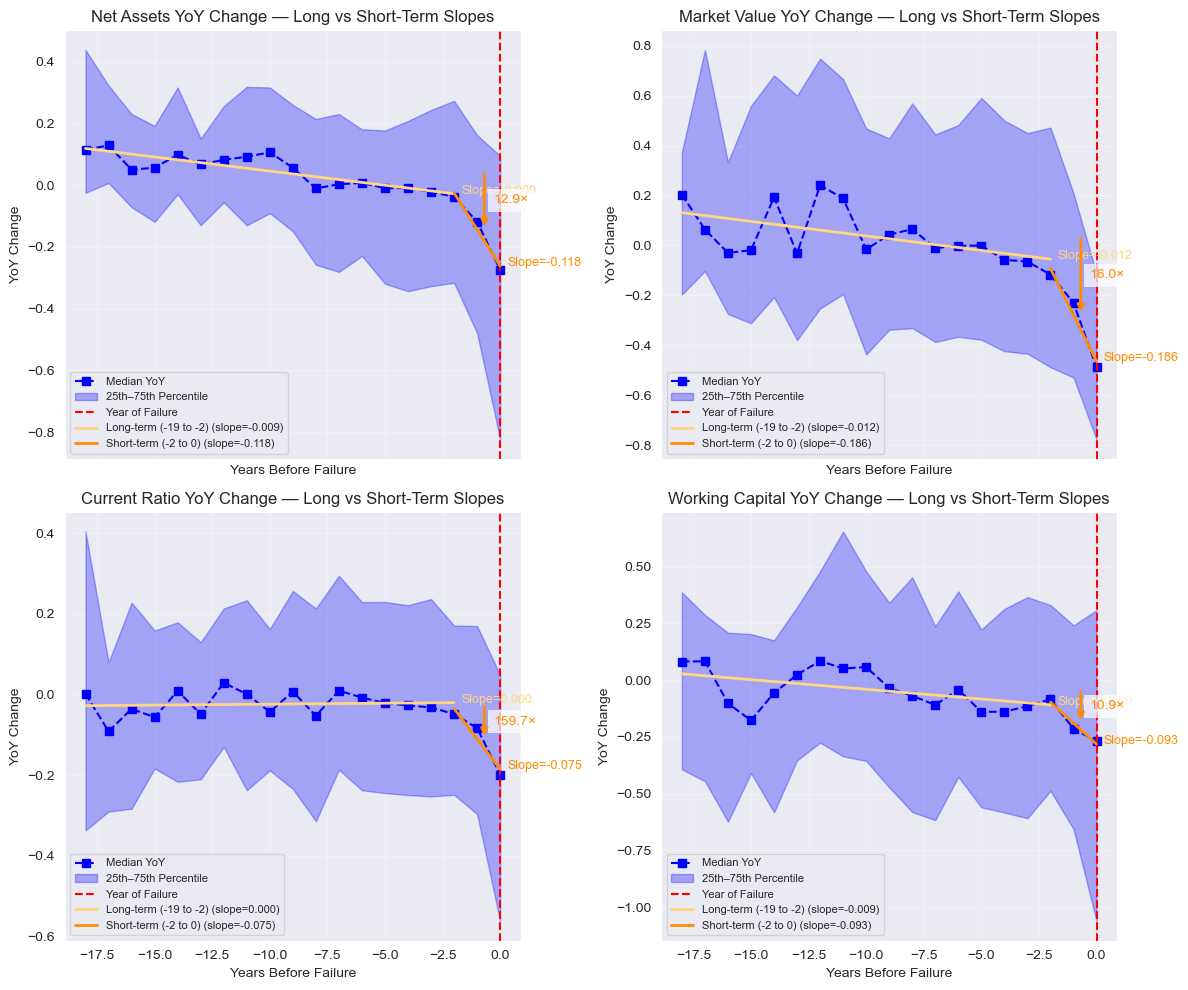

In [291]:
# Settings
# ----------------------------
METRICS = [
    "Net Assets", "Market Value", "Current Ratio", "Working Capital"
]

SEGMENTS = {
    "Long-term (-19 to -2)": (-19, -2),
    "Short-term (-2 to 0)":  (-2, 0)
}

# Colors
LIGHT_ORANGE = "#FFD580"  # flatter slope
DARK_ORANGE  = "#FF8C00"  # steeper slope
LINE_COLOR   = "blue"      # context line for median YoY
IQR_COLOR    = "blue"

# ----------------------------
# Make subplots
# ----------------------------
n_metrics = len(METRICS)
n_cols = 2
n_rows = int(np.ceil(n_metrics / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows), sharex=True)
axes = axes.flatten()

# ----------------------------
# Loop over metrics
# ----------------------------
for i, metric in enumerate(METRICS):
    ax = axes[i]

    # Prep & YoY change
    df_sorted = df_failed.sort_values(["company_name", "years_before_failure"]).copy()
    yoy_col = f"{metric}_yoy"
    df_sorted[yoy_col] = df_sorted.groupby("company_name")[metric].pct_change()

    # Aggregate to median & IQR
    grouped = df_sorted.groupby("years_before_failure")[yoy_col]
    median = grouped.median()
    q25 = grouped.quantile(0.25).reindex(median.index)
    q75 = grouped.quantile(0.75).reindex(median.index)

    if median.dropna().empty:
        ax.set_title(f"{metric} — Not enough data")
        ax.axis("off")
        continue

    # Context: median & IQR band
    ax.plot(median.index, median.values,
            label="Median YoY", linestyle="--", marker="s", color=LINE_COLOR)
    ax.fill_between(median.index, q25, q75,
                    alpha=0.3, label="25th–75th Percentile", color=IQR_COLOR)
    ax.axvline(0, color="red", linestyle="--", label="Year of Failure")

    # Compute slopes for each segment
    slopes_info = {}  # label -> dict(x, slope, fitted, mean_fitted)
    for label, (start, end) in SEGMENTS.items():
        seg = median.loc[start:end].dropna()
        if len(seg.index) >= 2:
            x = seg.index.values.astype(float)
            y = seg.values.astype(float)
            slope, intercept = np.polyfit(x, y, 1)
            fitted = slope * x + intercept
            slopes_info[label] = {
                "x": x,
                "slope": slope,
                "fitted": fitted,
                "mean_fitted": np.nanmean(fitted)
            }

    # Assign colors by |slope| and identify steeper/flatter
    colors = {}
    flatter_label = None
    steeper_label = None
    if len(slopes_info) >= 2:
        labels_by_steepness = sorted(slopes_info.keys(), key=lambda L: abs(slopes_info[L]["slope"]))
        flatter_label = labels_by_steepness[0]
        steeper_label = labels_by_steepness[-1]
        for L in slopes_info.keys():
            colors[L] = LIGHT_ORANGE if L == flatter_label else DARK_ORANGE
    else:
        for L in slopes_info.keys():
            colors[L] = DARK_ORANGE

    # Plot segment fits + slope annotations
    for label, info in slopes_info.items():
        x = info["x"]
        fitted = info["fitted"]
        slope = info["slope"]
        c = colors[label]
        ax.plot(x, fitted, color=c, linewidth=2, label=f"{label} (slope={slope:.3f})")
        ax.annotate(f"Slope={slope:.3f}",
                    xy=(x[-1], fitted[-1]),
                    xytext=(5, 0), textcoords="offset points",
                    fontsize=9, color=c)

    # --- Down arrow & magnitude (steeper vs. flatter) ---
    # Arrow points DOWN from steeper mean_fitted to flatter mean_fitted
    if flatter_label and steeper_label:
        mf_flat = slopes_info[flatter_label]["mean_fitted"]
        mf_steep = slopes_info[steeper_label]["mean_fitted"]
        s_flat = abs(slopes_info[flatter_label]["slope"])
        s_steep = abs(slopes_info[steeper_label]["slope"])

        # Guard against zero/NaN
        if np.isfinite(mf_flat) and np.isfinite(mf_steep) and np.isfinite(s_flat) and s_flat != 0:
            ratio = s_steep / s_flat  # how many times steeper vs flatter
            label_txt = f"{ratio:.1f}×"

            # Place arrow near right edge
            xmin, xmax = ax.get_xlim()
            x_span = xmax - xmin if xmax > xmin else 1.0
            x_annot = xmax - 0.08 * x_span  # 8% from the right

            # Ensure arrow points down; if not, swap y's for annotation only
            y_top = mf_steep
            y_bottom = mf_flat
            if y_top < y_bottom:
                y_top, y_bottom = y_bottom, y_top  # enforce downward arrow

            # Draw arrow (color = dark orange to match steeper)
            ax.annotate(
                '',
                xy=(x_annot, y_bottom),
                xytext=(x_annot, y_top),
                arrowprops=dict(arrowstyle='-|>', color=DARK_ORANGE, lw=2),
                zorder=5
            )

            # Label at midpoint, a bit to the right
            y_mid = (y_top + y_bottom) / 2
            ax.text(
                x_annot + 0.02 * x_span, y_mid,
                label_txt,
                va='center', ha='left', fontsize=10, color=DARK_ORANGE,
                bbox=dict(fc='white', ec='none', alpha=0.7)
            )

    # Titles, labels
    ax.set_title(f"{metric} YoY Change — Long vs Short-Term Slopes")
    ax.set_xlabel("Years Before Failure")
    ax.set_ylabel("YoY Change")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc="best")

# Hide unused axes if metrics don’t fill the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

####
*Four of the 8 fundamentals also signal the presence of a potential “Warning Window”. Among them, Current Ratio declines the fastest, falling nearly 160× faster, while Working Capital declines the slowest but still at a significant pace — about 11× faster on average - in the two years leading up to bankruptcy.*   
####

### Visualization 7: Failed Firms 4-Year Warning Windows

####
*I will now check if any of the other metrics have different Warning Windows.*
####

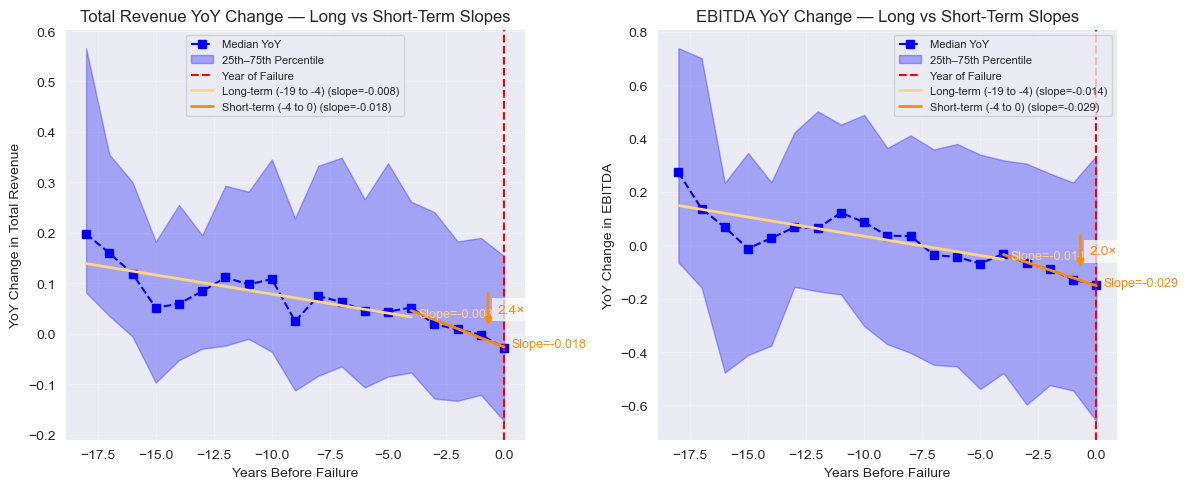

In [303]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================
# Settings
# =========================================
METRICS = ["Total Revenue", "EBITDA"]

# Slope segments (same as your example)
SEGMENTS = {
    "Long-term (-19 to -4)": (-19, -4),
    "Short-term (-4 to 0)":  (-4, 0)
}

# Colors
LIGHT_ORANGE = "#FFD580"   # flatter slope
DARK_ORANGE  = "#FF8C00"   # steeper slope
MEDIAN_LINE  = "blue"     # context median YoY line
IQR_FILL     = "blue"      # context IQR band
YEAR0_LINE   = "red"

# =========================================
# Helper to plot one metric
# =========================================
def plot_metric_with_slopes(ax, df_failed, metric):
    # Sort and compute company-level YoY for the metric
    df_sorted = df_failed.sort_values(["company_name", "years_before_failure"]).copy()
    yoy_col = f"{metric}_yoy"
    df_sorted[yoy_col] = df_sorted.groupby("company_name")[metric].pct_change()

    # Median YoY by relative year (+ IQR)
    grouped = df_sorted.groupby("years_before_failure")[yoy_col]
    median = grouped.median()
    q25 = grouped.quantile(0.25).reindex(median.index)
    q75 = grouped.quantile(0.75).reindex(median.index)

    if median.dropna().empty:
        ax.set_title(f"{metric} — Not enough data")
        ax.axis("off")
        return

    # Context: median & IQR
    ax.plot(median.index, median.values,
            label="Median YoY", linestyle="--", marker="s", color=MEDIAN_LINE)
    ax.fill_between(median.index, q25, q75, alpha=0.3,
                    label="25th–75th Percentile", color=IQR_FILL)
    ax.axvline(0, color=YEAR0_LINE, linestyle="--", label="Year of Failure")

    # --- Fit slopes for each segment ---
    # Store x, fitted line, slope, and a stable anchor (mean of fitted) for each segment
    seg_info = {}
    for label, (start, end) in SEGMENTS.items():
        seg = median.loc[start:end].dropna()
        if len(seg.index) >= 2:
            x = seg.index.values.astype(float)
            y = seg.values.astype(float)
            slope, intercept = np.polyfit(x, y, 1)
            fitted = slope * x + intercept
            seg_info[label] = {
                "x": x,
                "fitted": fitted,
                "slope": slope,
                "mean_fitted": np.nanmean(fitted)
            }

    if not seg_info:
        ax.set_title(f"{metric} — Not enough segment data")
        return

    # --- Determine steeper vs flatter by absolute slope ---
    labels_sorted = sorted(seg_info.keys(), key=lambda L: abs(seg_info[L]["slope"]))
    flatter_label = labels_sorted[0]
    steeper_label = labels_sorted[-1]

    # Assign colors
    colors = {
        flatter_label: LIGHT_ORANGE,
        steeper_label: DARK_ORANGE
    }

    # Plot each segment's fitted line + slope annotation
    for label, info in seg_info.items():
        x = info["x"]; fitted = info["fitted"]; slope = info["slope"]
        c = colors.get(label, DARK_ORANGE)
        ax.plot(x, fitted, color=c, linewidth=2, label=f"{label} (slope={slope:.3f})")
        ax.annotate(f"Slope={slope:.3f}",
                    xy=(x[-1], fitted[-1]),
                    xytext=(5, 0), textcoords="offset points",
                    fontsize=9, color=c)

    # --- Down arrow from steeper to flatter + magnitude label ---
    if flatter_label in seg_info and steeper_label in seg_info:
        s_flat  = abs(seg_info[flatter_label]["slope"])
        s_steep = abs(seg_info[steeper_label]["slope"])

        if np.isfinite(s_flat) and s_flat != 0 and np.isfinite(s_steep):
            ratio = s_steep / s_flat
            label_txt = f"{ratio:.1f}×"

            # Use mean of fitted lines as stable y-anchors
            y_top = seg_info[steeper_label]["mean_fitted"]
            y_bot = seg_info[flatter_label]["mean_fitted"]

            # Ensure the arrow visually points down
            if y_top < y_bot:
                y_top, y_bot = y_bot, y_top

            xmin, xmax = ax.get_xlim()
            x_span = xmax - xmin if xmax > xmin else 1.0
            x_annot = xmax - 0.08 * x_span  # near the right edge

            # Draw downward arrow (steeper color)
            ax.annotate(
                '',
                xy=(x_annot, y_bot),
                xytext=(x_annot, y_top),
                arrowprops=dict(arrowstyle='-|>', color=DARK_ORANGE, lw=2),
                zorder=5
            )

            # Label at midpoint
            y_mid = (y_top + y_bot) / 2.0
            ax.text(
                x_annot + 0.02 * x_span, y_mid,
                label_txt,
                va='center', ha='left', fontsize=10, color=DARK_ORANGE,
                bbox=dict(fc='white', ec='none', alpha=0.7)
            )

    # Final styling
    ax.set_title(f"{metric} YoY Change — Long vs Short-Term Slopes")
    ax.set_xlabel("Years Before Failure")
    ax.set_ylabel(f"YoY Change in {metric}")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc="best")


# =========================================
# Build the 1x2 grid for the two metrics
# =========================================
n_cols = 2
n_rows = int(np.ceil(len(METRICS) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows), sharex=True)
axes = axes.flatten()

for i, metric in enumerate(METRICS):
    plot_metric_with_slopes(axes[i], df_failed, metric)

# Hide any unused axes (if len(METRICS) not multiple of n_cols)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

####
*Two of the remaining 4 fundamentals also signal the presence of a potential “Warning Window”. Among them, Total Revenue declines the fastest, falling nearly 2.4× faster, while EBITDA declines the slowest but still at a significant pace — about 2× faster on average - in the four years leading up to bankruptcy.*

*The fact that multiple fundamentals accelerate downward in this critical window suggests that firms may enter a phase of compounding financial stress well before formal bankruptcy. This pattern strengthens the case for using volatility and sharp declines in liquidity and capital measures as early-warning indicators, highlighting the potential to identify distress while intervention is still possible.*
####

## Executive Summary

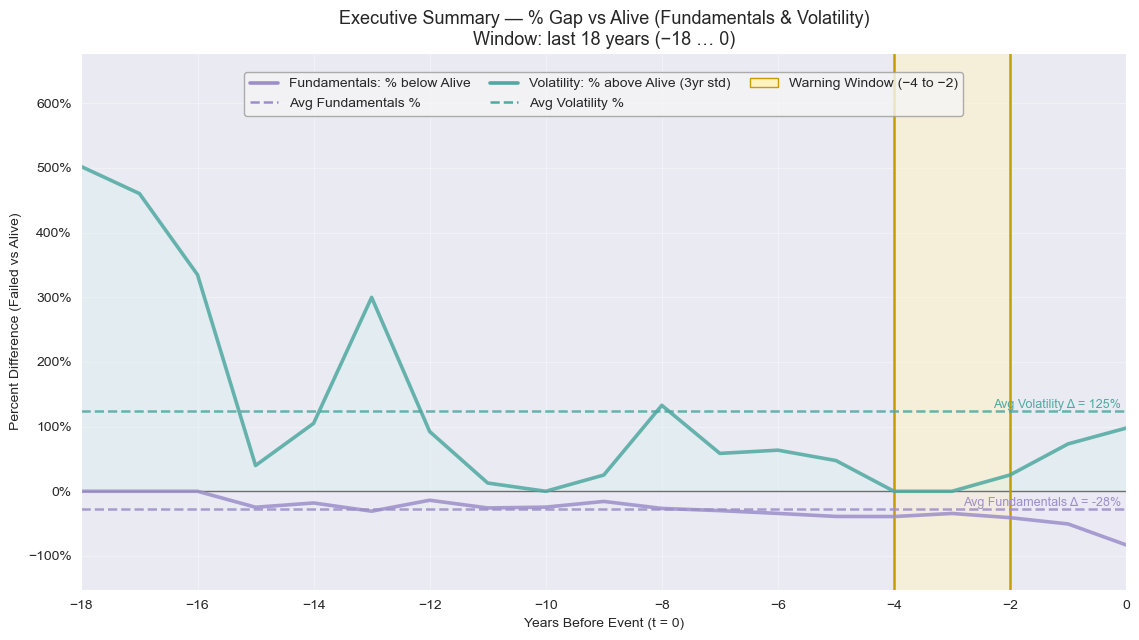

In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter

# -----------------------------
# CONFIG
# -----------------------------
METRICS = [
    "Net Assets", "Total Revenue",
    "EBITDA", "Market Value", "Net Income", "Retained Earnings",
    "Current Ratio", "Working Capital"
]

FAILED_YEAR_COL = "years_before_failure"
ALIVE_YEAR_COL  = "years_before_exit"

# --- Soft, light palette ---
# Volatility (std) = soft teal
TEAL_LINE = "#4FA8A1"    # line
TEAL_FILL = "#D6F2EE"    # fill

# Fundamentals = soft purple
PURPLE_LINE = "#9C8FC9"  # line
PURPLE_FILL = "#EDE8F7"  # fill

# Warning window (keep your yellow)
WIN_FILL    = "#FFF3C4"
WIN_OUTLINE = "#C59D00"  # subtle amber outline for the window edges

# Assign to plotting variables
VOL_LINE,  VOL_FILL  = TEAL_LINE,  TEAL_FILL    # Volatility: % above Alive (area ABOVE 0)
FUND_LINE, FUND_FILL = PURPLE_LINE, PURPLE_FILL # Fundamentals: % below Alive (area BELOW 0)

# Transparency for a light look
LINE_ALPHA = 0.85
FILL_ALPHA = 0.35

ZERO_COLOR  = "#6E6E6E"
WINDOW      = (-4, -2)   # warning window
ROLL_N      = 3          # rolling std window
YEARS_MIN, YEARS_MAX = -18, 0   # <-- use last 18 years

# -----------------------------
# HELPERS
# -----------------------------
def median_matrix_by_year(df, year_col, metrics):
    """Median by aligned year for each metric → DataFrame indexed by year."""
    return df.groupby(year_col)[metrics].median().sort_index()

def safe_pct_diff(num, den):
    """Compute (num - den) / den, safely avoiding divide-by-zero."""
    den_safe = den.replace(0, np.nan)
    pct = (num - den_safe) / den_safe
    return pct.fillna(0.0)

# -----------------------------
# BUILD SERIES
# -----------------------------
alive_med  = median_matrix_by_year(df_alive,  ALIVE_YEAR_COL,  METRICS)
failed_med = median_matrix_by_year(df_failed, FAILED_YEAR_COL, METRICS)

# Align & clip to [-18, 0]
x_all  = np.union1d(alive_med.index.values, failed_med.index.values)
mask   = (x_all >= YEARS_MIN) & (x_all <= YEARS_MAX)
x_plot = x_all[mask]
alive_med  = alive_med.reindex(x_plot)
failed_med = failed_med.reindex(x_plot)

# A) Fundamentals composite per year (sum across all 8 metric medians)
alive_fund  = alive_med.sum(axis=1, skipna=True)
failed_fund = failed_med.sum(axis=1, skipna=True)

# Fundamentals % difference (Failed vs Alive), clipped <= 0 (we only show "below Alive")
fund_pct = safe_pct_diff(failed_fund, alive_fund)  # (Failed-Alive)/Alive
fund_pct_below = np.minimum(fund_pct.values, 0.0)  # keep at/below 0

# B) Volatility (% difference) using 3-yr rolling std of median metrics, then mean across metrics
alive_roll_std  = alive_med.rolling(window=ROLL_N, center=True, min_periods=2).std()
failed_roll_std = failed_med.rolling(window=ROLL_N, center=True, min_periods=2).std()
alive_vol = alive_roll_std.mean(axis=1, skipna=True)
failed_vol = failed_roll_std.mean(axis=1, skipna=True)

# Volatility % difference (Failed vs Alive), clipped >= 0 (we only show "above Alive")
vol_pct = safe_pct_diff(failed_vol, alive_vol)     # (Failed-Alive)/Alive
vol_pct_above = np.maximum(vol_pct.values, 0.0)    # keep at/above 0

# -----------------------------
# PLOT
# -----------------------------
fig, ax = plt.subplots(figsize=(11.5, 6.5))

# Baseline & warning window with outlined edges
ax.axhline(0, color=ZERO_COLOR, lw=1)
ax.axvspan(WINDOW[0], WINDOW[1], color=WIN_FILL, alpha=0.55, label="_nolegend_")
ax.axvline(WINDOW[0], color=WIN_OUTLINE, lw=1.8)
ax.axvline(WINDOW[1], color=WIN_OUTLINE, lw=1.8)

# Fundamentals % below: line + fill BELOW 0 (soft purple)
ax.plot(x_plot, fund_pct_below, color=FUND_LINE, lw=2.6, alpha=LINE_ALPHA,
        label="Fundamentals: % below Alive (all 8 metrics)")
ax.fill_between(x_plot, 0, fund_pct_below,
                where=(fund_pct_below < 0),
                interpolate=True, color=FUND_FILL, alpha=FILL_ALPHA, label="_nolegend_")

# Average line for Fundamentals %
avg_fund = np.nanmean(fund_pct_below)
if np.isfinite(avg_fund):
    ax.axhline(avg_fund, color=FUND_LINE, linestyle="--", lw=1.8, alpha=LINE_ALPHA)
    ax.annotate(f"Avg Fundamentals Δ = {avg_fund:.0%}",
                xy=(0.995, avg_fund), xycoords=("axes fraction", "data"),
                ha="right", va="bottom", color=FUND_LINE, fontsize=9)

# Volatility % above: line + fill ABOVE 0 (soft teal)
ax.plot(x_plot, vol_pct_above, color=VOL_LINE, lw=2.6, alpha=LINE_ALPHA,
        label="Volatility: % above Alive (3yr std)")
ax.fill_between(x_plot, 0, vol_pct_above,
                where=(np.array(vol_pct_above) > 0),
                interpolate=True, color=VOL_FILL, alpha=FILL_ALPHA, label="_nolegend_")

# Average line for Volatility %
pos_vals = np.array(vol_pct_above)[np.isfinite(vol_pct_above)]
avg_vol = np.nanmean(pos_vals) if pos_vals.size else np.nan
if np.isfinite(avg_vol):
    ax.axhline(avg_vol, color=VOL_LINE, linestyle="--", lw=1.8, alpha=LINE_ALPHA)
    ax.annotate(f"Avg Volatility Δ = {avg_vol:.0%}",
                xy=(0.995, avg_vol), xycoords=("axes fraction", "data"),
                ha="right", va="bottom", color=VOL_LINE, fontsize=9)

# Labels, limits, percent axis
ax.set_title("Executive Summary — % Gap vs Alive (Fundamentals & Volatility)\nWindow: last 18 years (−18 … 0)", fontsize=13)
ax.set_xlabel("Years Before Event (t = 0)")
ax.set_ylabel("Percent Difference (Failed vs Alive)")
ax.set_xlim(YEARS_MIN, YEARS_MAX)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # show as %

# Y-limits with padding + extra headroom for legend inside
ymin = np.nanmin([np.nanmin(fund_pct_below), 0])  # include 0 reference
ymax = np.nanmax([np.nanmax(vol_pct_above), 0])
if not np.isfinite(ymin) or not np.isfinite(ymax):
    ymin, ymax = -0.1, 0.1
pad = (ymax - ymin) * 0.12 if ymax > ymin else 0.05
legend_headroom = (ymax - ymin) * 0.18
ax.set_ylim(ymin - pad, ymax + pad + legend_headroom)

# Legend INSIDE the plot, top-center
handles = [
    Line2D([0], [0], color=FUND_LINE, lw=2.6, label="Fundamentals: % below Alive"),
    Line2D([0], [0], color=FUND_LINE, lw=1.8, linestyle="--", label="Avg Fundamentals %"),
    Line2D([0], [0], color=VOL_LINE,  lw=2.6, label="Volatility: % above Alive (3yr std)"),
    Line2D([0], [0], color=VOL_LINE,  lw=1.8, linestyle="--", label="Avg Volatility %"),
    Patch(facecolor=WIN_FILL, edgecolor=WIN_OUTLINE, label="Warning Window (−4 to −2)")
]
leg = ax.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.98),
    ncol=3,
    frameon=True,
    borderaxespad=0.6,
    handletextpad=0.8,
    columnspacing=1.4
)
leg.get_frame().set_facecolor((0.96, 0.96, 0.96, 0.9))
leg.get_frame().set_edgecolor("#9A9A9A")

ax.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

**Aligned to t=0 (bankruptcy), failed firms show 125% higher volatility and 28% weaker fundamentals than alive peers. Starting 2–4 years pre-bankruptcy, their year-over-year fundamentals decline ~9× faster, marking a clear early-warning window.**

**The 8 key metrics that can be used to track these consistent, interpretable patterns distinguishing failed from alive firms are:** 

1) **Net Assets**
2) **Total Revenue**
3) **EBITDA**
4) **Market Value**
5) **Net Income**
6) **Retained Earnings**
7) **Current Ratio**
8) **Working Capital**

## Recommendations

### Bankruptcy Warning Signs and Tracking

**Monitoring cadence:** annual refresh (quarterly where data permits). Apply rules per company; trigger flags only when conditions are met after smoothing (3-yr centered std) and **consecutive-year persistence**.

- Persistent volatility uplift. 50-100% above alive companies for 3+ consecutive years (Current Ratio, Retained Earnings)
- Widening fundamentals gap. 25-35% below alive peers for 3+ consecutive years (Net Income, Retained Earnings)
- Early warning. Total Revenue or EBITDA average falls 1.5-2x for 2+ consecutive years
- Late warning. Other metrics’ average falls 4-12x in 1+ years (Market Value, Net Assets)
  
**Flagging logic:**  
- Raise **Watch** if any one rule triggers; raise **Alert** if **two+ rules** trigger within the same 2-yr window.
